In [1]:
import os
import sys
import numpy as np
import torch
import json
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from scipy.spatial import cKDTree

try:
    from OCC.Core import STEPControl, TopExp, TopAbs
    from OCC.Core.BRep import BRep_Tool
    from OCC.Core.gp import gp_Pnt

    from OCC.Core.BRepPrimAPI import (
        BRepPrimAPI_MakeBox, 
        BRepPrimAPI_MakeCylinder,
        BRepPrimAPI_MakeSphere,
        BRepPrimAPI_MakeCone
    )
    from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Fuse, BRepAlgoAPI_Cut
    from OCC.Core.gp import gp_Trsf, gp_Vec, gp_Ax2, gp_Pnt, gp_Dir
    from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform
    from OCC.Core.STEPControl import STEPControl_Writer, STEPControl_AsIs, STEPControl_Reader
    from OCC.Core.GProp import GProp_GProps
    from OCC.Core.BRepGProp import brepgprop
    from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape

except ImportError:
    print("Установите pythonocc-core: conda install -c conda-forge pythonocc-core=7.9.0")
    sys.exit(1)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"    

In [2]:
def read_step_file(filename):
    """Загружает STEP-файл и возвращает TopoDS_Shape"""
    reader = STEPControl.STEPControl_Reader()
    reader.ReadFile(str(filename))
    reader.TransferRoots()
    return reader.OneShape()


def extract_topology(shape):
    # Извлекает вершины и связи грань-вершина 
    vertices = []
    vertex_map = {}
    face_vertex_indices = []

    face_explorer = TopExp.TopExp_Explorer(shape, TopAbs.TopAbs_FACE)
    while face_explorer.More():
        face = face_explorer.Current()
        local_vertices = []

        edge_explorer = TopExp.TopExp_Explorer(face, TopAbs.TopAbs_EDGE)
        while edge_explorer.More():
            edge = edge_explorer.Current()
            
            # Вложенный эксплорер для вершин 
            vertex_explorer = TopExp.TopExp_Explorer(edge, TopAbs.TopAbs_VERTEX)
            while vertex_explorer.More():
                vertex = vertex_explorer.Current()
                p = BRep_Tool.Pnt(vertex)
                key = (round(p.X(), 6), round(p.Y(), 6), round(p.Z(), 6))
                if key not in vertex_map:
                    vertex_map[key] = len(vertices)
                    vertices.append(np.array([p.X(), p.Y(), p.Z()]))
                local_vertices.append(vertex_map[key])
                vertex_explorer.Next()
            
            edge_explorer.Next()

        if local_vertices:
            local_vertices = list(dict.fromkeys(local_vertices))
            face_vertex_indices.append(local_vertices)
        face_explorer.Next()

    return np.array(vertices), face_vertex_indices

def read_and_normalize_step(filename):
    """
    Загружает STEP-файл, извлекает вершины и грани, нормализует координаты вершин.
    
    Параметры:
        filename (str): путь к STEP-файлу
        
    Возвращает:
        shape: TopoDS_Shape исходной модели (для дальнейших вычислений, например, центра масс)
        norm_vertices (np.ndarray): нормализованные координаты вершин (форма N×3)
        face_vertex_indices (list): список индексов вершин для каждой грани
        center (np.ndarray): центр исходных вершин (3 элемента)
        scale (float): масштабный коэффициент (максимальное отклонение от центра)
    """
    # Чтение STEP-файла
    shape = read_step_file(filename)
    if shape is None:
        raise ValueError(f"Не удалось загрузить модель из {filename}")
    
    # Извлечение топологии (вершины и связи грань-вершина)
    vertices, face_vertex_indices = extract_topology(shape)
    if len(vertices) == 0:
        raise ValueError("Модель не содержит вершин")
    
    # Вычисление параметров нормализации
    center = vertices.mean(axis=0)
    scale = np.max(np.abs(vertices - center)) + 1e-8  # защита от деления на ноль
    
    # Нормализация вершин
    norm_vertices = (vertices - center) / scale
    
    return shape, norm_vertices, face_vertex_indices, center, scale

In [3]:
step_file_1 = "enhanced_dataset/raw/block_with_holes_000004.step"
step_file_2 = "enhanced_dataset/raw/block_with_holes_000007.step"
use_gnn = True  # Установите в False для использования эвристики без GNN
model_path = "gnn_best.pth"

In [4]:
print(f"📦 Загрузка моделей...")
print(f"   Модель 1: {step_file_1}")
print(f"   Модель 2: {step_file_2}")

# === Шаг 1: Загрузка моделей ===
shape1, vec1, face_vec_ind1, center1, scale1 = read_and_normalize_step(step_file_1)
shape2, vec2, face_vec_ind2, center2, scale2 = read_and_normalize_step(step_file_2)

if shape1 is None or shape2 is None:
    print("Не удалось загрузить одну или обе модели")
    
print("Модели успешно загружены")


📦 Загрузка моделей...
   Модель 1: enhanced_dataset/raw/block_with_holes_000004.step
   Модель 2: enhanced_dataset/raw/block_with_holes_000007.step
Модели успешно загружены


In [5]:
def build_graph(vertices, face_vertex_indices):
    n_vertices = len(vertices)
    n_faces = len(face_vertex_indices)

    node_coords = np.zeros((n_vertices + n_faces, 3))
    node_types = np.zeros(n_vertices + n_faces, dtype=int)

    # Вершины
    node_coords[:n_vertices] = vertices
    node_types[:n_vertices] = 0

    # Грани
    for i, vtx_ids in enumerate(face_vertex_indices):
        if vtx_ids:
            center = vertices[vtx_ids].mean(axis=0)
            node_coords[n_vertices + i] = center
            node_types[n_vertices + i] = 1

    # Рёбра
    edge_index = []
    for face_id, vtx_ids in enumerate(face_vertex_indices):
        for vtx_id in vtx_ids:
            edge_index.append([n_vertices + face_id, vtx_id])
            edge_index.append([vtx_id, n_vertices + face_id])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_coords, dtype=torch.float)
    node_type = torch.tensor(node_types, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, node_type=node_type)

In [6]:
def compute_center_of_mass(shape):
    """Вычисляет центр масс тела и возвращает как список [x, y, z]"""
    props = GProp_GProps()
    try:
        brepgprop.VolumeProperties(shape, props)
        cog = props.CentreOfMass()
        return [float(cog.X()), float(cog.Y()), float(cog.Z())]  # Список, не массив!
    except:
        from OCC.Core.Bnd import Bnd_Box
        from OCC.Core.BRepBndLib import brepbndlib_Add
        bbox = Bnd_Box()
        brepbndlib_Add(shape, bbox)
        xmin, ymin, zmin, xmax, ymax, zmax = bbox.Get()
        return [float((xmin+xmax)/2), float((ymin+ymax)/2), float((zmin+zmax)/2)]


In [7]:
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GNNModel(torch.nn.Module):
    def __init__(self, in_channels=3, hidden_dim=64, num_roles=4):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_dim, heads=4, concat=True, dropout=0.2)
        self.conv2 = GATv2Conv(hidden_dim * 4, hidden_dim, heads=2, concat=False, dropout=0.2)
        self.role_classifier = torch.nn.Linear(hidden_dim, num_roles)
        self.graph_proj = torch.nn.Linear(hidden_dim, 64)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        roles = self.role_classifier(x)
        graph_emb = global_mean_pool(x, batch)
        graph_emb = self.graph_proj(graph_emb)
        return roles, graph_emb

In [8]:
def find_elements_by_role(role_probs, node_types, coords, role_idx=3, top_k=3):
    """Находит элементы заданной роли (0=декор, 1=функциональная, 2=отверстия, 3=опорные плоскости)"""
    face_mask = (node_types == 1)
    if not np.any(face_mask):
        return np.array([])
    scores = role_probs[face_mask, role_idx]
    top_indices = np.argsort(-scores)[:top_k]
    face_indices = np.where(face_mask)[0][top_indices]
    return coords[face_indices]

In [10]:
def get_point_align(shape1, shape2, model_path="gnn_best.pth"):
    """
    Совмещение с использованием центра масс, отверстий и опорных плоскостей
    
    Возвращает:
        shape2_aligned : TopoDS_Shape или None
        R_mat : np.ndarray или None
        t_vec : np.ndarray или None
    """

    # 1. Проверка существования файла модели
    if not os.path.exists(model_path):
        print(f"❌ Модель {model_path} не найдена")
        return None, None, None
    
    # 2. Вычисление центра масс
    try:
        cog1 = np.array(compute_center_of_mass(shape1))
        cog2 = np.array(compute_center_of_mass(shape2))
        print("центра масс", cog1, cog2)

        cog1 = (cog1 - center1) / scale1
        cog2 = (cog2 - center2) / scale2

        print("центра масс нормализованные", cog1, cog2)

    except Exception as e:
        print(f"❌ Ошибка вычисления центра масс: {e}")
        return None, None, None
    
    # 3. Предсказание ролей через GNN
    try:
        g1 = build_graph(vec1, face_vec_ind1)
        g2 = build_graph(vec2, face_vec_ind2)
        
        model = GNNModel(in_channels=3, hidden_dim=64, num_roles=4)
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        model.eval()
        
        with torch.no_grad():
            batch1 = torch.zeros(g1.x.size(0), dtype=torch.long)
            batch2 = torch.zeros(g2.x.size(0), dtype=torch.long)
            roles1, _ = model(g1.x, g1.edge_index, batch1)
            roles2, _ = model(g2.x, g2.edge_index, batch2)
    except Exception as e:
        print(f"❌ Ошибка предсказания ролей: {e}")
        return None, None, None
    
    # 4. Сбор точек для совмещения
    points1 = [cog1]
    points2 = [cog2]
    
    # Отверстия (роль 2)
    holes1 = find_elements_by_role(roles1.softmax(dim=1).numpy(), g1.node_type.numpy(), g1.x[:, :3].numpy(), role_idx=2, top_k=2)
    holes2 = find_elements_by_role(roles2.softmax(dim=1).numpy(), g2.node_type.numpy(), g2.x[:, :3].numpy(), role_idx=2, top_k=2)
    points1.extend(holes1)
    points2.extend(holes2)
    
    # Опорные плоскости (роль 3)
    ref_planes1 = find_elements_by_role(roles1.softmax(dim=1).numpy(), g1.node_type.numpy(), g1.x[:, :3].numpy(), role_idx=3, top_k=2)
    ref_planes2 = find_elements_by_role(roles2.softmax(dim=1).numpy(), g2.node_type.numpy(), g2.x[:, :3].numpy(), role_idx=3, top_k=2)
    points1.extend(ref_planes1)
    points2.extend(ref_planes2)
    

    return points1, points2
   

In [12]:
print("   Используем обученную модель GNN для поиска опорных точек...")
p, q = get_point_align(shape1, shape2, model_path)

print(len(p), p)
print(len(q), q)


   Используем обученную модель GNN для поиска опорных точек...
центра масс [41.4144976 41.4144976 20.7072488] [58.94952153 58.94952153 29.47476077]
центра масс нормализованные [-4.58015267e-02  3.27420992e-16  8.18552479e-17] [-4.58015267e-02 -5.10659725e-14 -1.15013451e-16]
5 [array([-4.58015267e-02,  3.27420992e-16,  8.18552479e-17]), array([ 5.0763357e-01, -3.8167939e-01,  8.3266727e-17], dtype=float32), array([9.0839696e-01, 1.6653345e-16, 8.3266727e-17], dtype=float32), array([-1.0000000e+00,  1.6653345e-16,  8.3266727e-17], dtype=float32), array([-4.4656488e-01,  3.8167939e-01,  8.3266727e-17], dtype=float32)]
5 [array([-4.58015267e-02, -5.10659725e-14, -1.15013451e-16]), array([ 5.0763357e-01, -3.8167939e-01, -5.5511151e-17], dtype=float32), array([ 9.0839696e-01, -4.8683280e-14, -5.5511151e-17], dtype=float32), array([-1.000000e+00, -4.868328e-14, -5.551115e-17], dtype=float32), array([-4.4656488e-01,  3.8167939e-01, -5.5511151e-17], dtype=float32)]


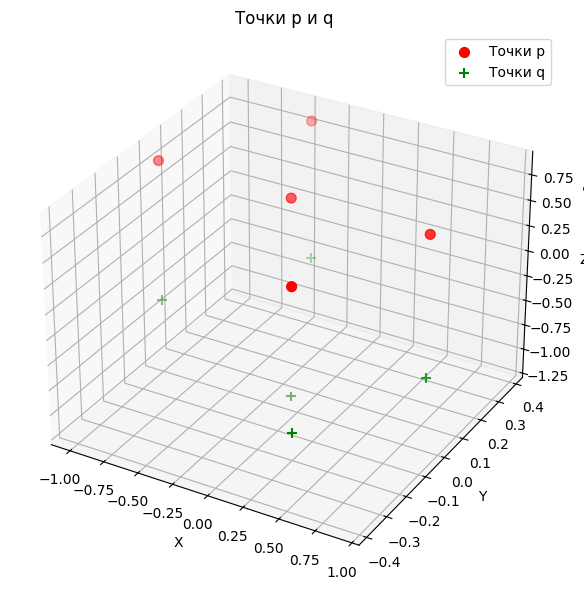

In [13]:
import matplotlib.pyplot as plt

p_array = np.array([np.array(pt, dtype=np.float64) for pt in p])
q_array = np.array([np.array(pt, dtype=np.float64) for pt in q])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(p_array[:, 0], p_array[:, 1], p_array[:, 2], 
           color='red', marker='o', s=50, label='Точки p')
ax.scatter(q_array[:, 0], q_array[:, 1], q_array[:, 2], 
           color='green', marker='+', s=50, label='Точки q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Точки p и q')
ax.legend()

plt.tight_layout()
plt.show()

In [14]:
src_mean = p_array.mean(axis=0)  
tgt_mean = q_array.mean(axis=0)  

p_ = p - src_mean  
q_ = q - tgt_mean

print(p_)
print(q_)

[[-3.05343500e-02  1.94194229e-16 -1.12918316e-18]
 [ 5.22900744e-01 -3.81679386e-01  2.82295790e-19]
 [ 9.23664136e-01  3.33066907e-17  2.82295790e-19]
 [-9.84732823e-01  3.33066907e-17  2.82295790e-19]
 [-4.31297706e-01  3.81679386e-01  2.82295790e-19]]
[[-3.05343500e-02 -2.13786088e-14 -4.76018402e-17]
 [ 5.22900744e-01 -3.81679386e-01  1.19004601e-17]
 [ 9.23664136e-01 -1.89959160e-14  1.19004601e-17]
 [-9.84732823e-01 -1.89959160e-14  1.19004601e-17]
 [-4.31297706e-01  3.81679386e-01  1.19004601e-17]]


In [15]:
H = p_.T @ q_
print(H)

[[ 2.28322942e+00 -3.64197878e-01  1.81686406e-18]
 [-3.64197878e-01  2.91358307e-01 -9.98071161e-33]
 [ 4.30985923e-20  3.01940794e-32  6.71889955e-35]]


In [33]:
U, S, Vt = np.linalg.svd(H)
print(U, S, Vt, sep="\n\n")

[[-9.84676140e-01 -1.74392948e-01 -2.35771417e-20]
 [ 1.74392948e-01 -9.84676140e-01 -2.94714266e-20]
 [-1.80762399e-20 -3.31314978e-20  1.00000000e+00]]

[2.34773138e+00 2.26856347e-01 6.71461590e-35]

[[-9.84676140e-01  1.74392948e-01 -7.71535295e-19]
 [-1.74392948e-01 -9.84676140e-01  4.35632522e-18]
 [ 0.00000000e+00  4.42411981e-18  1.00000000e+00]]


In [34]:
R_mat = Vt.T @ U.T
R_mat[2,2] = np.linalg.det(Vt.T @ U.T)
print(R_mat)

[[ 1.00000000e+00 -1.80258548e-15  2.35771417e-20]
 [ 1.81671640e-15  1.00000000e+00  4.45359124e-18]
 [-2.35771417e-20 -4.45359124e-18  1.00000000e+00]]


In [37]:
t_vec = []
for i in range(len(q_)):
    t_vec.append(q_[i] - R_mat @ p_[i])
print(t_vec)

[array([-2.55596239e-12, -2.15173308e-14, -4.64733770e-17]), array([6.38378239e-13, 2.88657986e-14, 9.93064880e-18]), array([ 6.39044373e-13, -2.07072584e-14,  1.16399416e-17]), array([ 6.39044373e-13, -1.72402424e-14,  1.15949471e-17]), array([6.39710507e-13, 3.05866443e-14, 1.33078395e-17])]


In [38]:
Q=[]
for i in range(len(q_)):
    Q.append(R_mat@q_[i]-t_vec[i])
print(Q)

[array([-3.05343500e-02,  8.32497200e-17, -1.12774334e-18]), array([ 5.22900744e-01, -3.81679386e-01,  3.65732672e-18]), array([9.23664136e-01, 3.38937825e-15, 2.38741070e-19]), array([-9.84732823e-01, -3.54465384e-15,  3.28730161e-19]), array([-4.31297706e-01,  3.81679386e-01, -3.09705462e-18])]


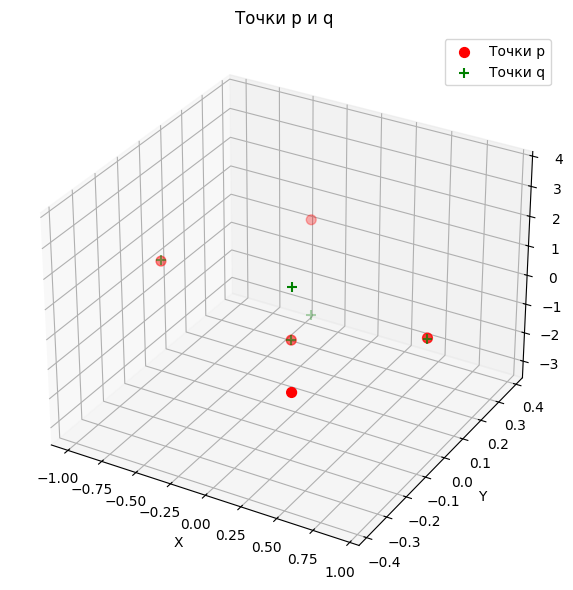

In [39]:
import matplotlib.pyplot as plt

p_array = np.array([np.array(pt, dtype=np.float64) for pt in p_])
q_array = np.array([np.array(pt, dtype=np.float64) for pt in Q])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(p_array[:, 0], p_array[:, 1], p_array[:, 2], 
           color='red', marker='o', s=50, label='Точки p')
ax.scatter(q_array[:, 0], q_array[:, 1], q_array[:, 2], 
           color='green', marker='+', s=50, label='Точки q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Точки p и q')
ax.legend()

plt.tight_layout()
plt.show()

In [40]:
trsf = gp_Trsf()
trsf.SetValues(
            float(R_mat[0,0]), float(R_mat[0,1]), float(R_mat[0,2]), float(t_vec[0]),
            float(R_mat[1,0]), float(R_mat[1,1]), float(R_mat[1,2]), float(t_vec[1]),
            float(R_mat[2,0]), float(R_mat[2,1]), float(R_mat[2,2]), float(t_vec[2])
        )
transform = BRepBuilderAPI_Transform(shape2, trsf)
shape2_aligned = transform.Shape()

writer = STEPControl.STEPControl_Writer()
writer.Transfer(shape2_aligned, STEPControl.STEPControl_AsIs)
status = writer.Write("outputs/results/aligned_model.step")

TypeError: only length-1 arrays can be converted to Python scalars

In [20]:
def evaluate_alignment(shape1, shape2_aligned, n_max_vertices=2000):
    """
    Оценка качества совмещения через расстояния между вершинами и поверхностями
    
    Параметры:
    ----------
    shape1 : TopoDS_Shape
        Первая модель (эталон)
    shape2_aligned : TopoDS_Shape
        Вторая модель после совмещения
    n_max_vertices : int
        Максимальное число вершин для анализа (0 = без ограничения)
    
    Возвращает:
    -----------
    dict : Метрики качества совмещения
    """
    from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
    from scipy.spatial import cKDTree
    import numpy as np
    
    # === Шаг 1: Минимальное расстояние между ПОВЕРХНОСТЯМИ (не Хаусдорф!) ===
    dist_checker = BRepExtrema_DistShapeShape()
    dist_checker.LoadS1(shape1)
    dist_checker.LoadS2(shape2_aligned)
    dist_checker.Perform()
    
    if not dist_checker.IsDone():
        return {'success': False, 'error': 'Расчёт расстояния между поверхностями не удался'}
    
    min_surface_dist = dist_checker.Value()  # Минимальное расстояние между ближайшими точками поверхностей
    
    # === Шаг 2: Извлечение вершин ===
    vertices1, _ = extract_topology(shape1)
    vertices2, _ = extract_topology(shape2_aligned)
    
    if len(vertices1) == 0 or len(vertices2) == 0:
        return {'success': False, 'error': 'Не удалось извлечь вершины из моделей'}
    
    # === Шаг 3: Ограничение числа вершин с защитой от ошибок ===
    def safe_sample(vertices, max_n):
        if max_n <= 0 or len(vertices) <= max_n:
            return vertices
        # Безопасная выборка только если max_n < len(vertices)
        indices = np.random.choice(len(vertices), max_n, replace=False)
        return vertices[indices]
    
    vertices1 = safe_sample(vertices1, n_max_vertices)
    vertices2 = safe_sample(vertices2, n_max_vertices)
    
    # === Шаг 4: Расчёт расстояний до ближайших точек ===
    tree2 = cKDTree(vertices2)
    dists12, _ = tree2.query(vertices1, k=1)  # Расстояния от модели 1 к модели 2
    
    tree1 = cKDTree(vertices1)
    dists21, _ = tree1.query(vertices2, k=1)  # Расстояния от модели 2 к модели 1
    
    # === Шаг 5: Вычисление метрик БЕЗ дублирования ===
    # Симметричное расстояние Хаусдорфа (максимальное из двух направлений)
    hausdorff_sym = max(dists12.max(), dists21.max())
    
    # Среднее расстояние (усреднённое по обоим направлениям)
    mean_dist = (dists12.mean() + dists21.mean()) / 2.0
    
    # RMS расстояние (усреднённое по обоим направлениям для симметрии)
    rms_dist = np.sqrt((np.concatenate([dists12, dists21])**2).mean())
    
    # Процент точек в допусках (только от модели 1 к модели 2 — логично для совмещения)
    inlier_01 = (dists12 < 0.1).mean()  # Точки с ошибкой < 0.1 мм
    inlier_10 = (dists12 < 1.0).mean()  # Точки с ошибкой < 1.0 мм
    
    return {
        'success': True,
        # Расстояния между поверхностями
        'min_surface_distance': min_surface_dist,  # Минимальное расстояние между поверхностями (не Хаусдорф!)
        # Расстояния Хаусдорфа по вершинам
        'hausdorff_symmetric': hausdorff_sym,      # Симметричное расстояние Хаусдорфа
        'hausdorff_forward': dists12.max(),        # Макс. расстояние от модели 1 к модели 2
        'hausdorff_backward': dists21.max(),       # Макс. расстояние от модели 2 к модели 1
        # Средние метрики
        'mean_distance': mean_dist,                 # Среднее расстояние (оба направления)
        'rms_distance': rms_dist,                   # RMS расстояние (оба направления)
        # Процент точек в допусках (от модели 1 к модели 2)
        'inlier_ratio_0.1mm': inlier_01,
        'inlier_ratio_1.0mm': inlier_10,
        # Информация о выборке
        'sample_count_model1': len(vertices1),
        'sample_count_model2': len(vertices2),
        'total_sampled_points': len(vertices1) + len(vertices2)
    }

In [21]:
try:
        metrics = evaluate_alignment(shape1, shape2_aligned, n_max_vertices=2000)
        
        if metrics['success']:
            print(f"   Минимальное расстояние между поверхностями: {metrics['min_surface_distance']:.4f} мм")
            print(f"   Симметричное расстояние Хаусдорфа: {metrics['hausdorff_symmetric']:.4f} мм")
            print(f"   Среднее расстояние: {metrics['mean_distance']:.4f} мм")
            print(f"   RMS расстояние: {metrics['rms_distance']:.4f} мм")
            print(f"   Точек с ошибкой < 0.1 мм: {metrics['inlier_ratio_0.1mm']*100:.1f}%")
            print(f"   Точек с ошибкой < 1.0 мм: {metrics['inlier_ratio_1.0mm']*100:.1f}%")
        else:
            print(f"⚠️ Ошибка оценки: {metrics['error']}")
            metrics = None
except Exception as e:
        print(f"⚠️ Ошибка при оценке качества: {e}")
        metrics = None

   Минимальное расстояние между поверхностями: 0.0000 мм
   Симметричное расстояние Хаусдорфа: 0.0000 мм
   Среднее расстояние: 0.0000 мм
   RMS расстояние: 0.0000 мм
   Точек с ошибкой < 0.1 мм: 100.0%
   Точек с ошибкой < 1.0 мм: 100.0%


In [22]:
import os  # ← КРИТИЧЕСКИ ВАЖНО: добавлен импорт!

def boolean_operations(shape1, shape2_aligned, tolerance=1e-3):
    """
    Выполняет булевы операции напрямую с TopoDS_Shape (без приведения типов)
    Добавлена проверка пересечения и обработка пустых результатов
    """
    from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Fuse, BRepAlgoAPI_Common, BRepAlgoAPI_Cut
    from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
    
    results = {}
    errors = []
    
    # === Проверка пересечения моделей (новое!) ===
    dist_checker = BRepExtrema_DistShapeShape()
    dist_checker.LoadS1(shape1)
    dist_checker.LoadS2(shape2_aligned)
    dist_checker.Perform()
    
    if dist_checker.IsDone() and dist_checker.Value() > 1.0:  # 1 мм порог
        print("⚠️ Модели не пересекаются — булевы операции могут быть некорректными")
        # Продолжаем выполнение, но предупреждаем пользователя
    
    # === Объединение (A ∪ B) ===
    try:
        fuse = BRepAlgoAPI_Fuse(shape1, shape2_aligned)
        fuse.SetFuzzyValue(tolerance)
        if fuse.IsDone() and not fuse.Shape().IsNull():
            results['fuse'] = fuse.Shape()
        else:
            errors.append("fuse: операция не выполнена или результат пустой")
    except Exception as e:
        errors.append(f"fuse: {str(e)}")
    
    # === Пересечение (A ∩ B) ===
    try:
        common = BRepAlgoAPI_Common(shape1, shape2_aligned)
        common.SetFuzzyValue(tolerance)
        if common.IsDone() and not common.Shape().IsNull():
            results['common'] = common.Shape()
        else:
            errors.append("common: операция не выполнена или результат пустой")
    except Exception as e:
        errors.append(f"common: {str(e)}")
    
    # === Разность (A \ B) ===
    try:
        cut1 = BRepAlgoAPI_Cut(shape1, shape2_aligned)
        cut1.SetFuzzyValue(tolerance)
        if cut1.IsDone() and not cut1.Shape().IsNull():
            results['diff1'] = cut1.Shape()
        else:
            errors.append("diff1: операция не выполнена или результат пустой")
    except Exception as e:
        errors.append(f"diff1: {str(e)}")
    
    # === Разность (B \ A) ===
    try:
        cut2 = BRepAlgoAPI_Cut(shape2_aligned, shape1)
        cut2.SetFuzzyValue(tolerance)
        if cut2.IsDone() and not cut2.Shape().IsNull():
            results['diff2'] = cut2.Shape()
        else:
            errors.append("diff2: операция не выполнена или результат пустой")
    except Exception as e:
        errors.append(f"diff2: {str(e)}")
    
    # === Симметрическая разность (A\B) ∪ (B\A) ===
    if 'diff1' in results and 'diff2' in results:
        try:
            symdiff = BRepAlgoAPI_Fuse(results['diff1'], results['diff2'])
            symdiff.SetFuzzyValue(tolerance)
            if symdiff.IsDone() and not symdiff.Shape().IsNull():
                results['symdiff'] = symdiff.Shape()
            else:
                errors.append("symdiff: операция не выполнена или результат пустой")
        except Exception as e:
            errors.append(f"symdiff: {str(e)}")
    
    if errors:
        results['errors'] = errors
    
    return results


def compute_volumes(shape):
    """Вычисляет объём и площадь поверхности (работает с любым TopoDS_Shape)"""
    from OCC.Core.GProp import GProp_GProps
    from OCC.Core.BRepGProp import brepgprop_VolumeProperties, brepgprop_SurfaceProperties
    
    volume = 0.0
    area = 0.0
    
    # Объём (только для тел)
    try:
        props = GProp_GProps()
        brepgprop_VolumeProperties(shape, props)
        # Проверка на валидность результата
        vol = props.Mass()
        if vol > 0 and not (vol != vol):  # not NaN
            volume = vol
    except Exception as e:
        print(f"⚠️ Ошибка вычисления объёма: {e}")
        volume = 0.0
    
    # Площадь поверхности (для всех типов)
    try:
        props = GProp_GProps()
        brepgprop_SurfaceProperties(shape, props)
        surf_area = props.Mass()
        if surf_area > 0 and not (surf_area != surf_area):  # not NaN
            area = surf_area
    except Exception as e:
        print(f"⚠️ Ошибка вычисления площади: {e}")
        area = 0.0
    
    return volume, area


def analyze_differences(shape1, shape2_aligned, tolerance=1e-3):
    """Полный анализ различий через булевы операции с защитой от деления на ноль"""
    results = boolean_operations(shape1, shape2_aligned, tolerance)
    
    vol1, area1 = compute_volumes(shape1)
    vol2, area2 = compute_volumes(shape2_aligned)
    
    vol_diff1 = compute_volumes(results['diff1'])[0] if 'diff1' in results else 0.0
    vol_diff2 = compute_volumes(results['diff2'])[0] if 'diff2' in results else 0.0
    vol_common = compute_volumes(results['common'])[0] if 'common' in results else 0.0
    
    # Защита от деления на ноль
    total_vol = max(vol1, vol2, 1e-6)  # Минимум 1е-6 для избежания деления на ноль
    diff_percent = ((vol_diff1 + vol_diff2) / total_vol * 100)
    
    # Дополнительные метрики для интерпретации
    similarity_percent = (vol_common / total_vol * 100) if total_vol > 0 else 0.0
    
    return {
        'volume_model1': vol1,
        'volume_model2': vol2,
        'volume_unique_to_1': vol_diff1,
        'volume_unique_to_2': vol_diff2,
        'volume_common': vol_common,
        'difference_percent': diff_percent,
        'similarity_percent': similarity_percent,  # Новое! Процент совпадения
        'area_model1': area1,
        'area_model2': area2,
        'results': results
    }


def save_boolean_results(results, output_dir="outputs/boolean"):
    """Сохраняет результаты булевых операций в STEP-файлы с проверкой на пустые результаты"""
    from OCC.Core.STEPControl import STEPControl_Writer, STEPControl_AsIs
    
    # Создание директории с полной проверкой
    os.makedirs(output_dir, exist_ok=True)
    
    saved = []
    failed = []
    
    mapping = {
        'fuse': 'union.step',
        'common': 'intersection.step',
        'diff1': 'unique_to_model1.step',
        'diff2': 'unique_to_model2.step',
        'symdiff': 'all_differences.step'
    }
    
    for key, filename in mapping.items():
        if key in results:
            try:
                # Проверка на пустой результат
                if results[key].IsNull():
                    print(f"⚠️ Пропущено сохранение {filename}: результат пустой")
                    failed.append(filename)
                    continue
                
                writer = STEPControl_Writer()
                writer.Transfer(results[key], STEPControl_AsIs)
                filepath = os.path.join(output_dir, filename)
                status = writer.Write(filepath)
                
                if status == 1:  # IFSelect_RetDone
                    saved.append(filename)
                    print(f"✅ Сохранено: {filename}")
                else:
                    failed.append(filename)
                    print(f"⚠️ Не удалось сохранить {filename} (статус: {status})")
            except Exception as e:
                failed.append(filename)
                print(f"❌ Ошибка сохранения {filename}: {e}")
    
    if failed:
        print(f"\n⚠️ Не удалось сохранить {len(failed)} файл(ов): {', '.join(failed)}")
    
    return saved

In [23]:
results = boolean_operations(shape1, shape2_aligned, tolerance=1e-3)

In [24]:
vol1, area1 = compute_volumes(shape1)
vol2, area2 = compute_volumes(shape2_aligned)

vol_diff1 = compute_volumes(results['diff1'])[0] if 'diff1' in results else 0.0
vol_diff2 = compute_volumes(results['diff2'])[0] if 'diff2' in results else 0.0
vol_common = compute_volumes(results['common'])[0] if 'common' in results else 0.0

total_vol = max(vol1, vol2, 1e-6)  # Защита от деления на ноль
diff_percent = ((vol_diff1 + vol_diff2) / total_vol * 100)
similarity_percent = (vol_common / total_vol * 100) if total_vol > 0 else 0.0

print(f"   Объём модели 1:     {vol1:.2f} мм³")
print(f"   Объём модели 2:     {vol2:.2f} мм³")
print(f"   Уникально модели 1: {vol_diff1:.2f} мм³")
print(f"   Уникально модели 2: {vol_diff2:.2f} мм³")
print(f"   Общая часть:        {vol_common:.2f} мм³")
print(f"   📌 Различия:        {diff_percent:.2f}%")
print(f"   ✅ Совпадение:      {similarity_percent:.2f}%")

# Интерпретация результатов
if similarity_percent > 99.9:
    print("✅ Модели практически идентичны")
elif similarity_percent > 99.0:
    print("⚠️  Модели очень похожи (возможны допуски производства)")
elif similarity_percent > 95.0:
    print("🔶 Модели умеренно различаются")
else:
    print("❌ Модели значительно различаются")

analysis = {
    'volume_model1': vol1,
    'volume_model2': vol2,
    'volume_unique_to_1': vol_diff1,
    'volume_unique_to_2': vol_diff2,
    'volume_common': vol_common,
    'difference_percent': diff_percent,
    'similarity_percent': similarity_percent,
    'area_model1': area1,
    'area_model2': area2,
    'results': results
}


   Объём модели 1:     275560.90 мм³
   Объём модели 2:     275560.90 мм³
   Уникально модели 1: 0.00 мм³
   Уникально модели 2: 0.00 мм³
   Общая часть:        275560.90 мм³
   📌 Различия:        0.00%
   ✅ Совпадение:      100.00%
✅ Модели практически идентичны


/var/folders/0t/6sq2wg4j0416j_4tk2z0wgfh0000gn/T/ipykernel_24674/4001759991.py:97: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.VolumeProperties
  brepgprop_VolumeProperties(shape, props)
/var/folders/0t/6sq2wg4j0416j_4tk2z0wgfh0000gn/T/ipykernel_24674/4001759991.py:109: DeprecationWarning: Call to deprecated function brepgprop_SurfaceProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.SurfaceProperties
  brepgprop_SurfaceProperties(shape, props)
/var/folders/0t/6sq2wg4j0416j_4tk2z0wgfh0000gn/T/ipykernel_24674/4001759991.py:97: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.VolumeProperties
  brepgpro

In [50]:
saved_files = []
try:
            os.makedirs("outputs/boolean", exist_ok=True)
            
            mapping = {
                'fuse': 'union.step',
                'common': 'intersection.step',
                'diff1': 'unique_to_model1.step',
                'diff2': 'unique_to_model2.step',
                'symdiff': 'all_differences.step'
            }
            
            for key, filename in mapping.items():
                if key in analysis['results']:
                    try:
                        writer = STEPControl_Writer()
                        writer.Transfer(analysis['results'][key], STEPControl_AsIs)
                        filepath = os.path.join("outputs/boolean", filename)
                        status = writer.Write(filepath)
                        
                        if status == 1:
                            saved_files.append(filename)
                            print(f"   ✅ {filename}")
                        else:
                            print(f"   ⚠️  Не удалось сохранить {filename} (статус: {status})")
                    except Exception as e:
                        print(f"   ⚠️  Ошибка сохранения {filename}: {e}")
            
            if saved_files:
                print(f"\n💡 Откройте 'all_differences.step' в FreeCAD для визуализации различий")
except Exception as e:
            print(f"⚠️ Ошибка при сохранении результатов: {e}")

   ✅ union.step
   ✅ intersection.step
   ✅ unique_to_model1.step
   ✅ unique_to_model2.step
   ✅ all_differences.step

💡 Откройте 'all_differences.step' в FreeCAD для визуализации различий
